## Семинар 6 "Segmentation"

ФИО: ___Перфильева Нелли Андреевна___, ник nelliperfileva (из-за использования авторизации по google acccount) - а на сайте поменять ник нельзя 

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 ноября 2021). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi


Mon Nov  8 15:24:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install imagecodecs;
!pip install pytorch_lightning;

     |████████████████████████████████| 29.6 MB 60 kB/s 
     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 132 kB 46.7 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 829 kB 38.6 MB/s 
     |████████████████████████████████| 329 kB 36.3 MB/s 
     |████████████████████████████████| 1.1 MB 32.6 MB/s 
     |████████████████████████████████| 192 kB 46.9 MB/s 
     |████████████████████████████████| 271 kB 47.0 MB/s 
     |████████████████████████████████| 160 kB 44.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=70c8030f5759a3b53c9ae66f15161637d10965d9be567462982dd1f5633b2acf
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled 

In [ ]:
!pip install imagecodecs;
!pip install pytorch_lightning;

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
import torch.nn.functional as F
from torchvision import transforms as tsf
import scipy.misc
import torch.nn as nn
from pathlib import Path
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import imagecodecs

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

from PIL import Image
import skimage
from skimage import io
import sys
from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter

from random import choice
from random import uniform

import tensorflow as tf
import datetime, os


TRAIN_PATH = './train.pth'
TEST_PATH = './test.tph'
%matplotlib inline

In [ ]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data

test = process('/content/drive/MyDrive/DRIVE/test/images/')
t.save(test, TEST_PATH)
train_data = process('/content/drive/MyDrive/DRIVE/training/images', "/content/drive/MyDrive/DRIVE/training/1st_manual/")

In [ ]:
import PIL

class GaussianNoise(object):
  def __init__(self, mean=0., std=1.):
    self.std = std
    self.mean = mean

  def __call__(self, tensor):
    return tensor + t.randn(tensor.size()) * self.std + self.mean

class Dataset():

    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform

    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        angle = choice([-1, -5, 1, 3, 5, 7, 90, 270, 60])
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        img = tsf.functional.rotate(img, angle)
        mask = tsf.functional.rotate(mask, angle)
        
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    # tsf.Resize((256,256)),
    tsf.ToTensor(),
    GaussianNoise(0., 0.01),
    tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5]), 
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    # tsf.Resize((256,256),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

In [ ]:
X_train = []
for data in dataset:
  X_train.append(data)
  img, mask = data
  X_train.append((tsf.functional.rotate(img, 45), tsf.functional.rotate(mask, 45)))
  X_train.append((tsf.functional.rotate(img, 90), tsf.functional.rotate(mask, 90)))
  X_train.append((tsf.functional.rotate(img, 180), tsf.functional.rotate(mask, 180)))
  X_train.append((tsf.functional.rotate(img, 270), tsf.functional.rotate(mask, 270)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1080x504 with 0 Axes>

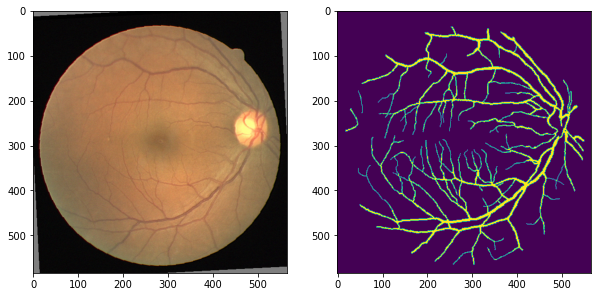

In [ ]:
plt.figure(figsize=(15, 7))

img, mask = dataset[17]

fig, ax = plt.subplots(1, 2, figsize=(10,20))
ax[0].imshow(img.permute(1,2,0).numpy()*0.5+0.5)
ax[1].imshow(mask[0].numpy());

In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        self.conv = double_conv(in_ch, out_ch) 

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = double_conv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.sigmoid(x)
        return x

In [ ]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [ ]:
model = UNet(3, 1)

device = t.device("cuda:0" if t.cuda.is_available() else "cpu")
model.to(device)
loss = soft_dice_loss
optimizer = t.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_network(network, train_loader, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or soft_dice_loss
    train_loss_epochs = []
    optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)
    # logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            for X, y in train_loader:
                X = X.to('cuda')
                y = y.to('cuda')
                network.zero_grad()
                prediction = network.forward(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.cpu().item())
                loss_batch.backward()
                optimizer.step()
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            sys.stdout.write('\rEpoch {0}... (Train) LOSS: {1:.3f}'.format(
                            epoch, train_loss_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs,

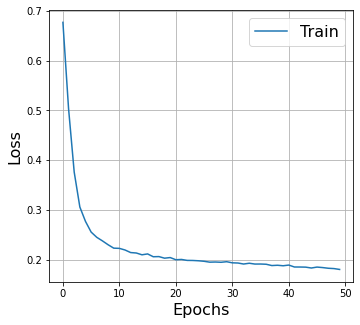

100%|██████████| 50/50 [1:39:18<00:00, 119.16s/it]


In [ ]:
dataloader = t.utils.data.DataLoader(X_train, num_workers=2, batch_size=4, shuffle=True)

loss_res = train_network(model, dataloader,  50, 0.001)

In [ ]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

In [ ]:
import skimage.transform
import imageio
import scipy.misc

In [ ]:
path = "result_19"
os.makedirs(path)


In [ ]:
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True).cuda()
    o = model(data)
    
    source_image = io.imread("drive/MyDrive/DRIVE/test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("./%s/%s.png" % (path, ex_id + 1), tm)

In [ ]:
plt.figure(figsize=(15, 7))
tm=o[0][0].data.cpu().numpy()
plt.subplot(121)
plt.imshow(data[0].data.cpu().permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(tm)

In [ ]:
!zip -r /content/result_19.zip /content/result_19

  adding: content/result_18/ (stored 0%)
  adding: content/result_18/8.png (deflated 1%)
  adding: content/result_18/11.png (deflated 1%)
  adding: content/result_18/18.png (deflated 1%)
  adding: content/result_18/13.png (deflated 1%)
  adding: content/result_18/17.png (deflated 1%)
  adding: content/result_18/6.png (deflated 1%)
  adding: content/result_18/10.png (deflated 1%)
  adding: content/result_18/15.png (deflated 1%)
  adding: content/result_18/16.png (deflated 1%)
  adding: content/result_18/20.png (deflated 1%)
  adding: content/result_18/9.png (deflated 1%)
  adding: content/result_18/2.png (deflated 1%)
  adding: content/result_18/14.png (deflated 1%)
  adding: content/result_18/4.png (deflated 1%)
  adding: content/result_18/12.png (deflated 1%)
  adding: content/result_18/7.png (deflated 1%)
  adding: content/result_18/1.png (deflated 1%)
  adding: content/result_18/3.png (deflated 1%)
  adding: content/result_18/19.png (deflated 1%)
  adding: content/result_18/5.png (d

In [ ]:
from google.colab import files
files.download("/content/" + path + ".zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Использование аугментации в виде поворотов на небольшие углы(1-3-7) и гауссовского шума позволили достичь скора 0.79, а увеличение размера трейнового множества посредством добавления повортов на угол, кратный 90 градусов, поспособствовало получению скора 0.81
